## Lab | Making predictions with logistic regression

Use Sakila database of movie rentals.

In order to optimize our inventory, we would like to know which films will be rented next month and we are asked to create a model to predict it.

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
password = getpass.getpass()
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

········


### Getting the data

In [3]:
query = '''SELECT film_id, title, rental_duration, rental_rate, length, replacement_cost, rating, special_features,
       COUNT(DISTINCT rental.rental_id) AS num_rentals,
       CASE WHEN MAX(rental_date) >= '2006-02-01' AND MAX(rental_date) < '2006-03-01' THEN TRUE ELSE FALSE END AS rented_last_month
FROM rental
JOIN inventory USING (inventory_id)
RIGHT JOIN film USING (film_id)
JOIN film_category USING (film_id)
JOIN category USING (category_id)
GROUP BY film_id;'''

In [4]:
data = pd.read_sql_query(query, engine)
data.head()

,film_id,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,num_rentals,rented_last_month
0,1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",24,0
1,2,ACE GOLDFINGER,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",7,1
2,3,ADAPTATION HOLES,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",12,0
3,4,AFFAIR PREJUDICE,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",23,1
4,5,AFRICAN EGG,6,2.99,130,22.99,G,Deleted Scenes,12,1


### Exploring the data

In [5]:
data.shape

(1000, 10)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   film_id            1000 non-null   int64  
 1   title              1000 non-null   object 
 2   rental_duration    1000 non-null   int64  
 3   rental_rate        1000 non-null   float64
 4   length             1000 non-null   int64  
 5   replacement_cost   1000 non-null   float64
 6   rating             1000 non-null   object 
 7   special_features   1000 non-null   object 
 8   num_rentals        1000 non-null   int64  
 9   rented_last_month  1000 non-null   int64  
dtypes: float64(2), int64(5), object(3)
memory usage: 78.2+ KB


In [7]:
data.isna().sum()

film_id              0
title                0
rental_duration      0
rental_rate          0
length               0
replacement_cost     0
rating               0
special_features     0
num_rentals          0
rented_last_month    0
dtype: int64

In [8]:
data.rating.nunique()

5

In [9]:
data.rating.unique()

array(['PG', 'G', 'NC-17', 'PG-13', 'R'], dtype=object)

In [10]:
data.rating.value_counts()

PG-13    223
NC-17    210
R        195
PG       194
G        178
Name: rating, dtype: int64

In [11]:
data.special_features.nunique()

15

In [12]:
data.special_features.unique()

array(['Deleted Scenes,Behind the Scenes', 'Trailers,Deleted Scenes',
       'Commentaries,Behind the Scenes', 'Deleted Scenes', 'Trailers',
       'Commentaries,Deleted Scenes',
       'Trailers,Deleted Scenes,Behind the Scenes',
       'Trailers,Commentaries,Behind the Scenes', 'Trailers,Commentaries',
       'Trailers,Behind the Scenes',
       'Commentaries,Deleted Scenes,Behind the Scenes',
       'Trailers,Commentaries,Deleted Scenes',
       'Trailers,Commentaries,Deleted Scenes,Behind the Scenes',
       'Behind the Scenes', 'Commentaries'], dtype=object)

In [13]:
data.special_features.value_counts()

Trailers,Commentaries,Behind the Scenes                   79
Trailers                                                  72
Trailers,Commentaries                                     72
Trailers,Behind the Scenes                                72
Deleted Scenes,Behind the Scenes                          71
Commentaries,Behind the Scenes                            70
Behind the Scenes                                         70
Trailers,Deleted Scenes                                   66
Commentaries,Deleted Scenes,Behind the Scenes             66
Commentaries,Deleted Scenes                               65
Trailers,Commentaries,Deleted Scenes                      64
Commentaries                                              62
Deleted Scenes                                            61
Trailers,Commentaries,Deleted Scenes,Behind the Scenes    61
Trailers,Deleted Scenes,Behind the Scenes                 49
Name: special_features, dtype: int64

### Cleaning the data

In [14]:
data.set_index('film_id', inplace=True)
data.head()

,title,rental_duration,rental_rate,length,replacement_cost,rating,special_features,num_rentals,rented_last_month
film_id,,,,,,,,,
1,ACADEMY DINOSAUR,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",24,0
2,ACE GOLDFINGER,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",7,1
3,ADAPTATION HOLES,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",12,0
4,AFFAIR PREJUDICE,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",23,1
5,AFRICAN EGG,6,2.99,130,22.99,G,Deleted Scenes,12,1


### EDA

In [15]:
data.describe()

,rental_duration,rental_rate,length,replacement_cost,num_rentals,rented_last_month
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,1000.000000
mean,4.985000,2.980000,115.272000,19.984000,16.04500,0.168000
std,1.411654,1.646393,40.426332,6.050833,7.34908,0.374053
min,3.000000,0.990000,46.000000,9.990000,0.00000,0.000000
25%,4.000000,0.990000,80.000000,14.990000,11.00000,0.000000
50%,5.000000,2.990000,114.000000,19.990000,16.00000,0.000000
75%,6.000000,4.990000,149.250000,24.990000,21.00000,0.000000
max,7.000000,4.990000,185.000000,29.990000,34.00000,1.000000


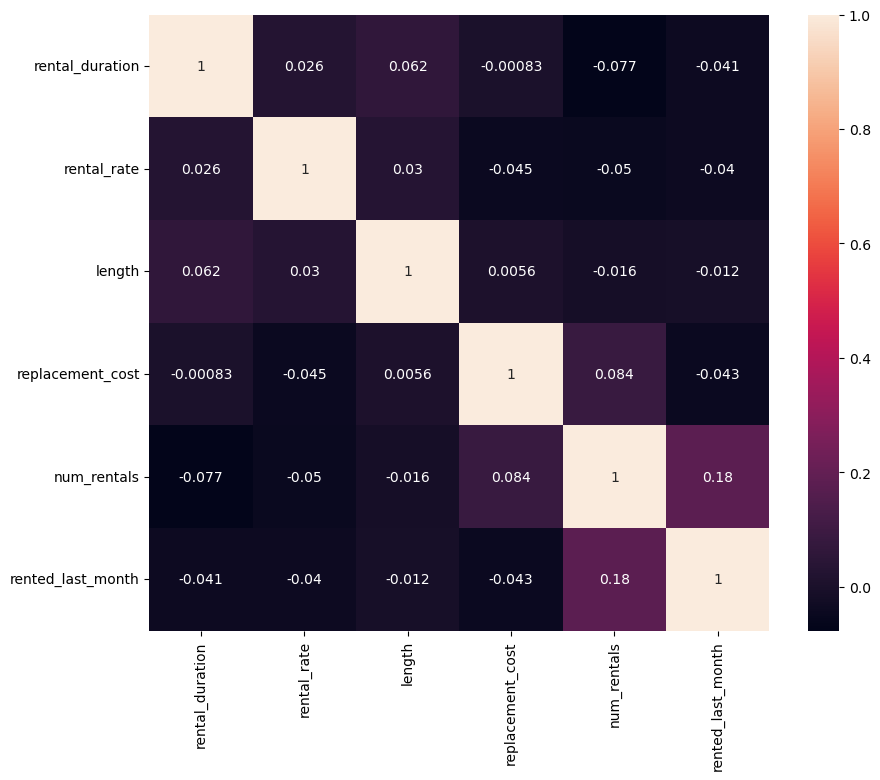

In [16]:
# Check correlations
corr_matrix=data.corr(method='pearson')
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [17]:
num = data.select_dtypes(include = np.number)
num = num.drop(['rented_last_month'], axis=1)
num.head()

,rental_duration,rental_rate,length,replacement_cost,num_rentals
film_id,,,,,
1,6,0.99,86,20.99,24
2,3,4.99,48,12.99,7
3,7,2.99,50,18.99,12
4,5,2.99,117,26.99,23
5,6,2.99,130,22.99,12


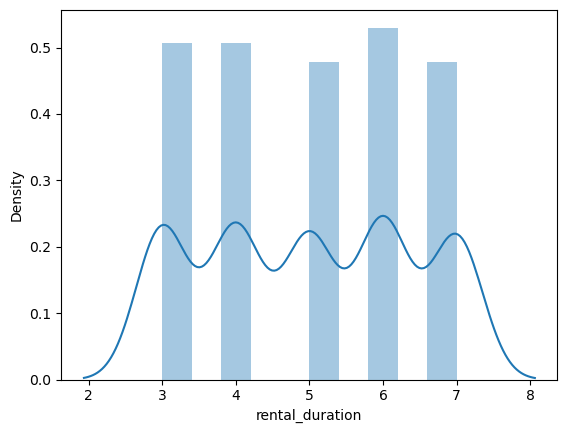

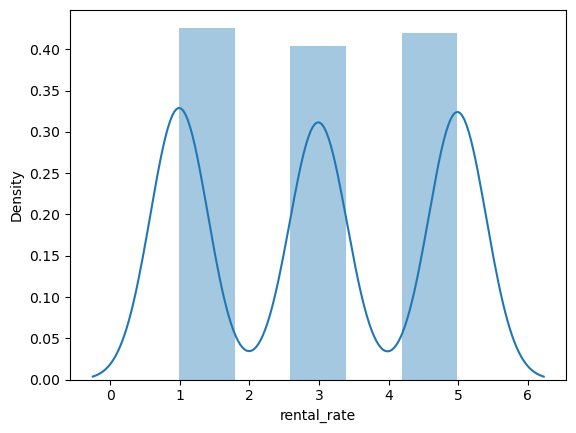

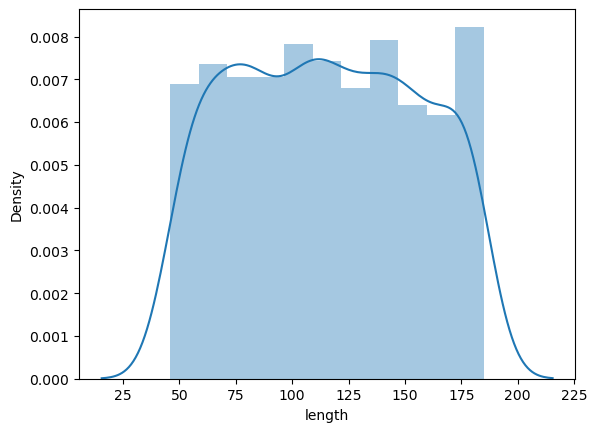

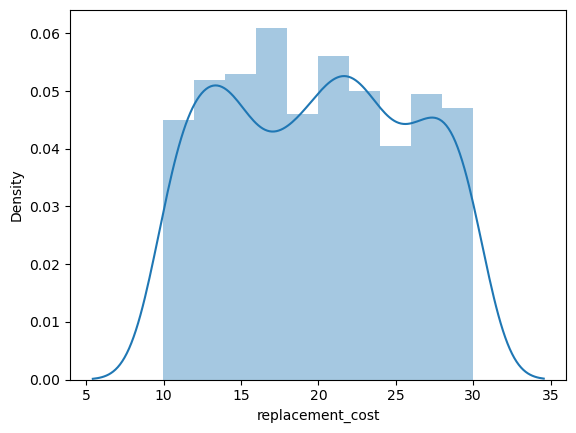

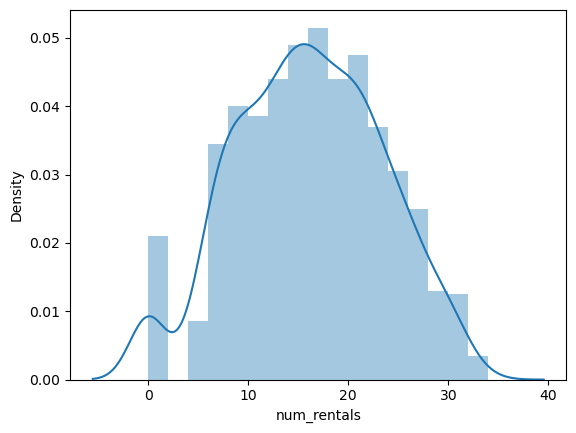

In [18]:
# Check distributions of numericals
for column in num.columns:
    sns.distplot(num[column])
    plt.xlabel(column)
    plt.show()

### Normalizing the data

In [19]:
# Normalize numericals
transformer = StandardScaler().fit(num)
x_normalized = transformer.transform(num)
x = pd.DataFrame(x_normalized, columns=num.columns, index=num.index)
x.head()

,rental_duration,rental_rate,length,replacement_cost,num_rentals
film_id,,,,,
1,0.719374,-1.209308,-0.724445,0.166341,1.082990
2,-1.406855,1.221461,-1.664897,-1.156452,-1.231382
3,1.428118,0.006077,-1.615399,-0.164357,-0.550684
4,0.010631,0.006077,0.042766,1.158437,0.946850
5,0.719374,0.006077,0.364499,0.497040,-0.550684


In [20]:
# Get dummies for column `rating`
rating = pd.get_dummies(data.rating)
rating.head()

,G,NC-17,PG,PG-13,R
film_id,,,,,
1,0,0,1,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,1,0,0,0,0
5,1,0,0,0,0


In [21]:
# Get dummies for column `special_features`
special_features = data.special_features.str.get_dummies(sep=',')
special_features.columns = ['deleted_scenes', 'behind_the_scenes', 'commentaries', 'trailers']
special_features.head()

,deleted_scenes,behind_the_scenes,commentaries,trailers
film_id,,,,
1,1,0,1,0
2,0,0,1,1
3,0,0,1,1
4,1,1,0,0
5,0,0,1,0


In [22]:
# Get categoricals
cat = pd.concat([rating, special_features], axis=1)
cat.head()

,G,NC-17,PG,PG-13,R,deleted_scenes,behind_the_scenes,commentaries,trailers
film_id,,,,,,,,,
1,0,0,1,0,0,1,0,1,0
2,1,0,0,0,0,0,0,1,1
3,0,1,0,0,0,0,0,1,1
4,1,0,0,0,0,1,1,0,0
5,1,0,0,0,0,0,0,1,0


### Train-Test Split and Training Model

In [23]:
# Target varible
y = data.rented_last_month

# Numericals and dummies from categoricals
X = pd.concat([x, cat], axis=1)
X.head()

,rental_duration,rental_rate,length,replacement_cost,num_rentals,G,NC-17,PG,PG-13,R,deleted_scenes,behind_the_scenes,commentaries,trailers
film_id,,,,,,,,,,,,,,
1,0.719374,-1.209308,-0.724445,0.166341,1.082990,0,0,1,0,0,1,0,1,0
2,-1.406855,1.221461,-1.664897,-1.156452,-1.231382,1,0,0,0,0,0,0,1,1
3,1.428118,0.006077,-1.615399,-0.164357,-0.550684,0,1,0,0,0,0,0,1,1
4,0.010631,0.006077,0.042766,1.158437,0.946850,1,0,0,0,0,1,1,0,0
5,0.719374,0.006077,0.364499,0.497040,-0.550684,1,0,0,0,0,0,0,1,0


In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [25]:
X_train

,rental_duration,rental_rate,length,replacement_cost,num_rentals,G,NC-17,PG,PG-13,R,deleted_scenes,behind_the_scenes,commentaries,trailers
film_id,,,,,,,,,,,,,,
421,1.428118,1.221461,-0.922435,-1.487151,-0.142266,0,0,0,1,0,1,1,0,1
279,1.428118,1.221461,0.908971,-1.321802,-0.822963,0,1,0,0,0,1,0,1,1
219,0.719374,1.221461,-1.590650,0.166341,-0.278405,0,0,0,1,0,1,1,0,0
364,-1.406855,0.006077,-1.046178,-0.825754,-1.095243,0,1,0,0,0,0,0,0,1
851,-1.406855,-1.209308,0.884223,0.000992,0.538432,0,0,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,0.010631,1.221461,-1.046178,-1.321802,1.219130,0,0,0,0,1,0,1,0,0
872,-1.406855,0.006077,1.725679,1.323786,-0.142266,0,0,0,0,1,0,0,1,0
836,-1.406855,0.006077,0.512992,-0.825754,-1.231382,0,0,1,0,0,1,1,1,0


In [26]:
y_train

film_id
421    0
279    0
219    1
364    0
851    0
      ..
856    0
872    0
836    0
793    0
521    0
Name: rented_last_month, Length: 700, dtype: int64

In [27]:
# Initialize logistic regression model
logreg = LogisticRegression()

In [28]:
# Train model on training data
logreg.fit(X_train, y_train)

LogisticRegression()

In [29]:
# Make predictions on testing data
y_pred = logreg.predict(X_test)

In [30]:
pd.Series(y_pred).value_counts()

0    300
dtype: int64

<AxesSubplot:>

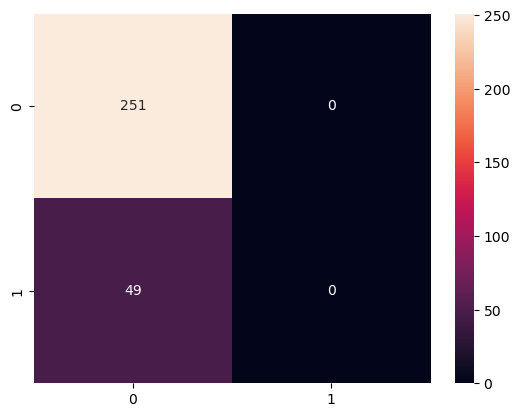

In [31]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True,fmt='g')

In [32]:
# Evaluate model performance using accuracy score
accuracy = accuracy_score(y_test, y_pred)
print('\nAccuracy: {:.2f}\n'.format(accuracy))


Accuracy: 0.84

